In [51]:
from gtda.plotting import plot_point_cloud
from generate_data import make_point_clouds

from gtda.mapper.cluster import FirstSimpleGap

from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# Data wrangling
import numpy as np
#import pandas as pd  # Not a requirement of giotto-tda, but is compatible with the gtda.mapper module

# TDA magic
from gtda.mapper import (
#    CubicalCover,
    make_mapper_pipeline,
#    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph
)

#import filtering functions
from gtda.mapper.filter import Eccentricity, Entropy, Projection

#import clustering functions
from gtda.mapper.cluster import ParallelClustering, Agglomerative, FirstHistogramGap

#import cover functions
from gtda.mapper.cover import OneDimensionalCover, CubicalCover

import open3d as o3d
from umap import UMAP

import gzip
import shutil
import os
import matplotlib.pyplot as plt

from copy import deepcopy
from pprint import pprint
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import matplotlib.patches as patches

In [181]:
def extract_gz_files(folder):
    r = []
    for file in os.listdir(folder):
        if file.split('.')[-1]=='gz':
            full_path = os.path.join(folder, file)
            file_extension = file.split('.')[-2]
            new_file_path = os.path.join(folder, ''.join(file.split('.')[:-2])+"."+str(file_extension))
            r.append(new_file_path)
            with gzip.open(full_path, 'rb') as f_in:
                with open(new_file_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
    return r

def get_ply_files(folder):
    files = list(filter(lambda file: file.split('.')[-1]=='ply', os.listdir(folder)))
    files = list(map(lambda file: os.path.join(folder, file),files))
    return files

In [256]:
#files = extract_gz_files('/Users/zanjonke/Downloads/tablesPly')
ply_files  = get_ply_files('data/tablesPly')
ply_files += get_ply_files('data/chairsPly')
ply_files += get_ply_files('data/cupsPly')
ply_files += get_ply_files('data/humansPly')

pcd = o3d.io.read_point_cloud(ply_files[10]) # Read the point cloud
pcd = np.asarray(pcd.points) 

In [229]:
point_clouds_basic, labels_basic = make_point_clouds(n_samples_per_shape=10, n_points=50, noise=0.2)
pcd = point_clouds_basic[10]

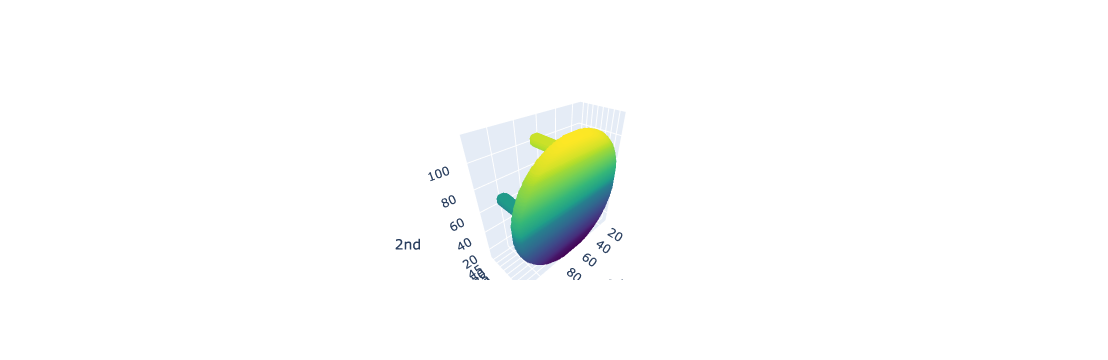

In [257]:
plot_point_cloud(pcd)

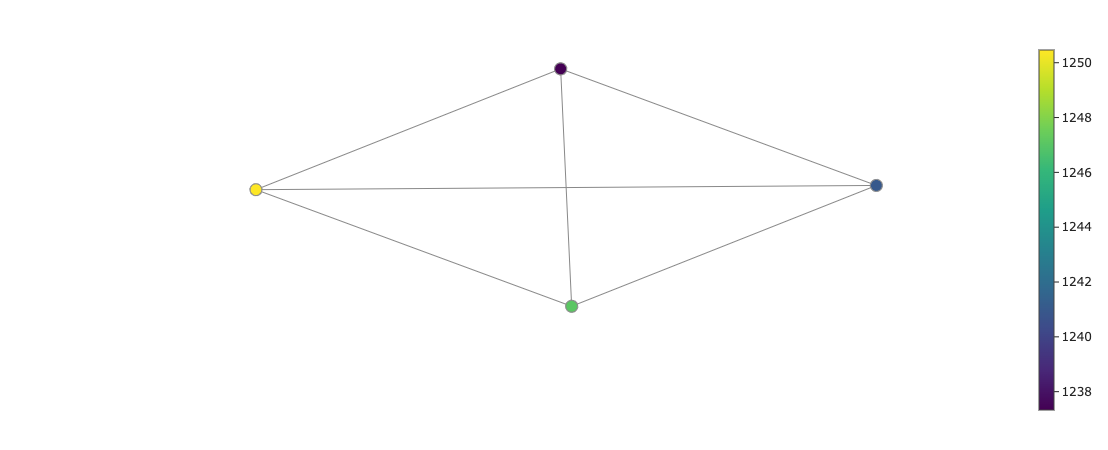

In [231]:
# Define filter function – can be any scikit-learn transformer
filter_func = Projection(columns=[0,1])
#filter_func = PCA()
#filter_func = Eccentricity()
#filter_func = Entropy()
#filter_func = Projection()
#filter_func = UMAP(n_neighbors=5)

# Define cover
cover = CubicalCover(n_intervals=2, overlap_frac=0.2)

# Choose clustering algorithm – default is DBSCAN
clusterer = DBSCAN(eps=10)

# Configure parallelism of clustering step
n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)
#plot_interactive_mapper_graph(pipe, pcd, color_data=pcd)
fig = plot_static_mapper_graph(pipe, pcd)
fig.show(config={'scrollZoom': True})

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
plt.scatter(X[:,0], X[:,1])

X_.shape: (2500, 2)


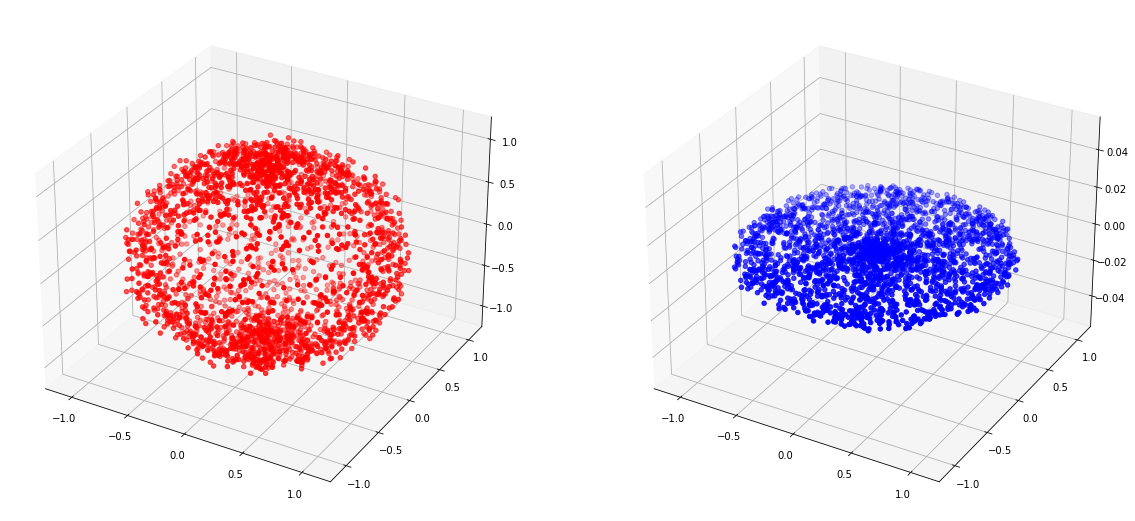

In [232]:

filter_func = Projection(columns=[0,1])
#filter_func = PCA()
#filter_func = UMAP(n_neighbors=5)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = deepcopy(pcd[:,0:3])
ax.scatter(X[:,0], X[:,1],X[:,2],color='r')

ax = fig.add_subplot(1, 2, 2, projection='3d')
X_ = filter_func.fit_transform(X)
print("X_.shape: " + str(X_.shape))
ax.scatter(X_[:,0], X_[:,1],[0]*X_.shape[0],color='b')
#ax.scatter(X_[:,0], X_[:,1],X_[:,2],color='b')

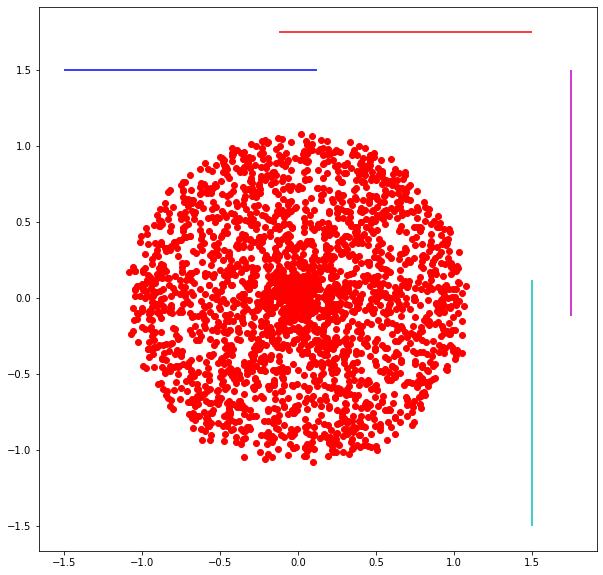

In [241]:
#cover = CubicalCover(n_intervals=2, overlap_frac=0.2)
cover = CubicalCover(n_intervals=2, overlap_frac=0.2)
X__ = cover.fit_transform(X_)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_[:,0],X_[:,1],color='r')

offset = 1.75
#offset = 4
lim = 1.5
#lim = 3.5
step = 0.25
lim_neg = -1.5
#lim_neg = -10
for i, (left_limit, right_limit) in enumerate(zip(cover._coverers[0].left_limits_, cover._coverers[0].right_limits_)):
    if left_limit == -np.inf: left_limit = lim_neg 
    if right_limit == np.inf: right_limit = lim
    color = 'b' if i %2 == 0 else 'r'
    y = offset-step if i %2 == 0 else offset
    ax.hlines(y=y, xmin=left_limit, xmax=right_limit, colors=color)

for i, (left_limit, right_limit) in enumerate(zip(cover._coverers[1].left_limits_, cover._coverers[1].right_limits_)):
    if left_limit == -np.inf: left_limit = lim_neg
    if right_limit == np.inf: right_limit = lim
    color = 'c' if i %2 == 0 else 'm'
    x = offset-step if i %2 == 0 else offset
    ax.vlines(x=x, ymin=left_limit, ymax=right_limit, colors=color)
    

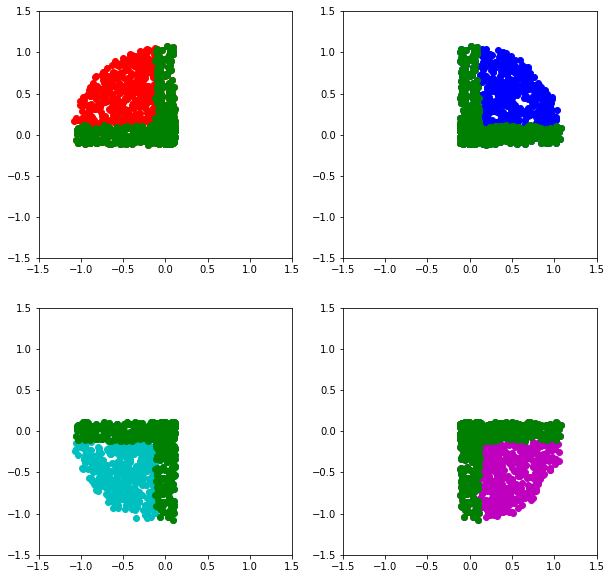

In [242]:
groups = [X[X__[:,i]] for i in range(0, X__.shape[1])]

groups = [groups[1], groups[3], groups[0], groups[2]] #just to have the plots in a nice manner
fig, ax = plt.subplots(2,2,figsize=(10,10))

colors = ['r','b','c','m']
for i in range(0,len(groups)):
    
    ax[i//2,i%2].scatter(groups[i][:,0], groups[i][:,1], color=colors[i])
    ax[i//2,i%2].set_xlim([-lim, lim])
    ax[i//2,i%2].set_ylim([-lim, lim])

s = [{tuple(p) for p in group} for group in groups]

intersections = []
for i,si in enumerate(s):
    intersecting_points = []
    for j,sj in enumerate(s):
        intersecting_points.append([list(p) for p in si & sj])
    intersections.append(intersecting_points)
    
for i,group_intersections in enumerate(intersections):
    for j, intersection in enumerate(group_intersections):
        if i == j:
            continue
        intersection= np.array(intersection)

        if intersection.size == 0:
            continue

        ax[i//2,i%2].scatter(intersection[:,0], intersection[:,1], color='g')

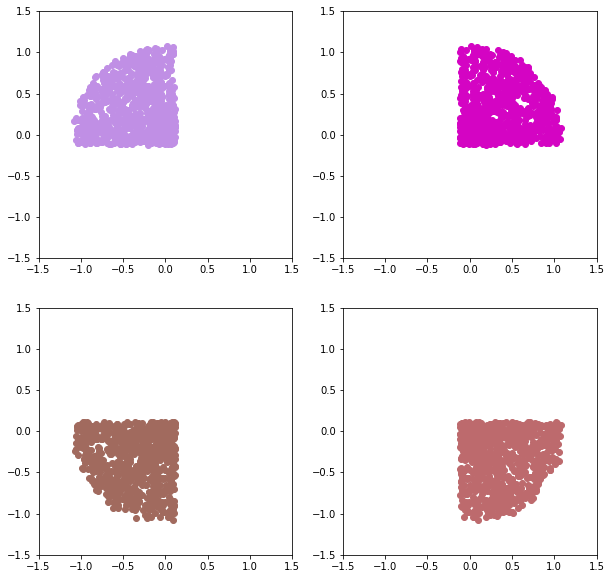

In [250]:
clusterer = DBSCAN(eps=1)
cluster_result_labels = [clusterer.fit(group).labels_ for group in groups]
#cluster_result_labels[0][0:30]= 1
fig, ax = plt.subplots(2,2,figsize=(10,10))
for i in range(0,len(groups)):
    for label in np.unique(cluster_result_labels[i]):
        cluster = groups[i][cluster_result_labels[i]==label]
        centroid = (np.mean(cluster[:,0]), np.mean(cluster[:,1]))
        c = np.random.rand(3,)
        #ax[i//2,i%2].scatter(centroid[0], centroid[1], color=c,s=1000)
        ax[i//2,i%2].scatter(cluster[:,0], cluster[:,1], color=c)
        ax[i//2,i%2].set_xlim([-lim, lim])
        ax[i//2,i%2].set_ylim([-lim, lim])

In [244]:
def get_cluster(cluster_result_labels, id_):
    for idx, cluster_i_labels in enumerate(cluster_result_labels):
        if id_ in cluster_i_labels:
            return idx, cluster_i_labels
    return -1, None

nodes = []
cluster_result_labels = [clusterer.fit(group).labels_ for group in groups]
#cluster_result_labels[0][0:30]= 1
for cluster_labels in cluster_result_labels:
    cluster_ids = np.unique(cluster_labels)
    unique_nodes = [len(nodes) + i for i, _ in enumerate(cluster_ids)]
    for cluster_id in cluster_ids:
        cluster_labels[cluster_labels==cluster_id] = unique_nodes[cluster_id]
     
    nodes += unique_nodes
    

    
    
edges = []
for node_i in nodes:
    idxi, cluster_labels_i = get_cluster(cluster_result_labels, node_i)
    cluster_i = groups[idxi][cluster_labels_i==node_i]
    cluster_i = {tuple(p) for p in cluster_i}
    for node_j in nodes:
        if node_i == node_j:
            continue
        idxj, cluster_labels_j = get_cluster(cluster_result_labels, node_j)
        cluster_j = groups[idxj][cluster_labels_j==node_j]
        cluster_j = {tuple(p) for p in cluster_j}
        intersection = cluster_i & cluster_j
        if len(intersection) > 0:
            edge = (node_i, node_j)

            if not edge in edges and not (edge[1],edge[0]) in edges:
                edges.append((node_i, node_j))



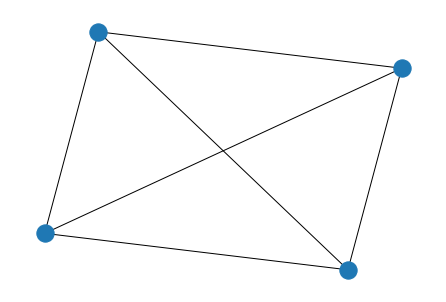

In [245]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G)